In [23]:
import numpy as np
import mne
import re
import matplotlib.pyplot as plt

import tracemalloc


In [25]:
%load_ext IPython.extensions.autoreload
%autoreload 2

import hypyp
import hypyp.fnirs as fnirs
from hypyp.wavelet.pywavelets_wavelet import PywaveletsWavelet
from hypyp.memory import MemoryMonitor


The IPython.extensions.autoreload extension is already loaded. To reload it, use:
  %reload_ext IPython.extensions.autoreload


## Download and load raw data from disk

In [3]:
# Download data

loader = fnirs.DataBrowser()
previous_count = len(loader.paths)
loader.download_demo_dataset()
#print(loader.list_all_files())


'/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers'

In [28]:
# Get the paths for dyads

paths = [path for path in loader.list_all_files() if 'fathers' in path]

dyad_paths = dict()

pattern = re.compile(r'.*/(FCS\d\d)/.*')
pattern_parent = re.compile(r'.*/parent/.*')
pattern_child = re.compile(r'.*/child/.*')

for path in paths:
    matches = pattern.match(path)
    key = matches[1]
    if not key in dyad_paths.keys():
        dyad_paths[key] = ['', '']
    
    if pattern_parent.match(path) is not None:
        dyad_paths[key][0] = path

    if pattern_child.match(path) is not None:
        dyad_paths[key][1] = path


print(dyad_paths)
    

{'FCS01': ['/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS01/parent/NIRS-2019-09-28_002.hdr', '/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS01/child/NIRS-2019-09-28_002.hdr'], 'FCS02': ['/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS02/parent/NIRS-2019-10-06_004.hdr', '/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS02/child/NIRS-2019-10-06_004.hdr'], 'FCS03': ['/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS03/parent/NIRS-2019-10-12_003.hdr', '/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS03/child/NIRS-2019-10-12_003.hdr'], 'FCS04': ['/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS04/parent/NIRS-2019-10-12_001.hdr', '/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS04/child/NIRS-2019-10-12_001.hdr'], 'FCS05': ['/home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS05/parent/NIRS-2019-10

## Intra subject validation

Loading /home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS01/parent/NIRS-2019-09-28_002.hdr


Reading 0 ... 3083  =      0.000 ...   394.624 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.05 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.05
- Lower transition bandwidth: 0.02 Hz (-6 dB cutoff frequency: 0.04 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.80 Hz)
- Filter length: 1291 samples (165.248 s)

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 470 original time points ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 470 original time points .

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


[MemoryMonitor] allocated: 74.66 M, peak: 78.04 M


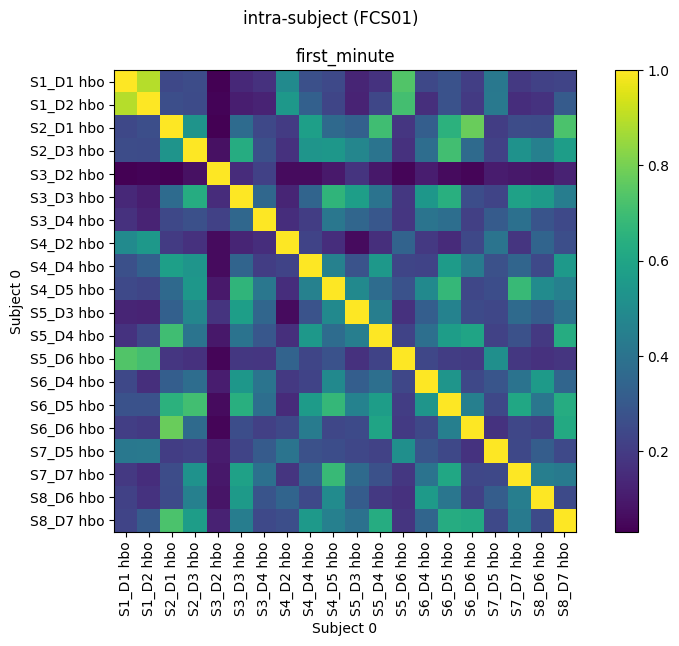

In [ ]:
# Get connectivity matrix intra-subject for validation

dyad_key = list(dyad_paths.keys())[0]
dyad_path = list(dyad_paths.values())[0][0]
#tasks = [('first_10_seconds', 0, 10), ('second_10_seconds', 10, 20)]
#tasks = [('foo', 0, 120)]
tasks = [('first_minute', 0, 60)]
#tasks = []

subject = fnirs.Subject(label='Subject 0', tasks_time_range=tasks).load_file(fnirs.MnePreprocessor(), dyad_path, preprocess=True)

with MemoryMonitor():
    dyad_intra_subject = fnirs.Dyad(subject, subject, label=f'intra-subject ({dyad_key})').populate_epochs_from_tasks().compute_wtcs(match='hbo')

dyad_intra_subject.plot_connectivity_matrices()
plt.show()



Downscaling for display by a factor of 4


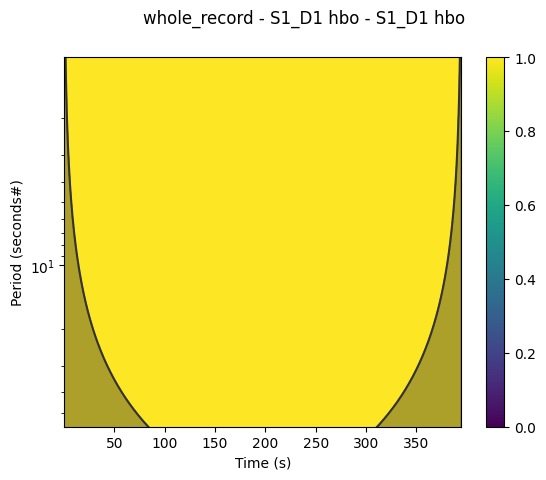

Downscaling for display by a factor of 4


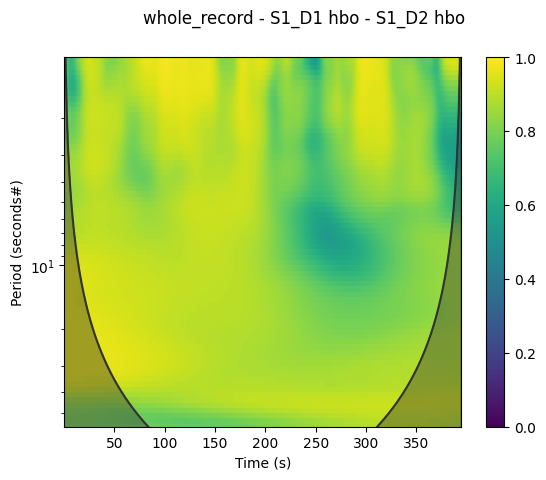

Downscaling for display by a factor of 4


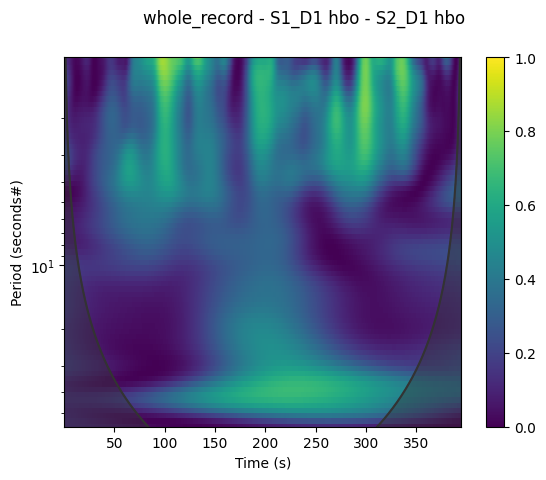

Downscaling for display by a factor of 4


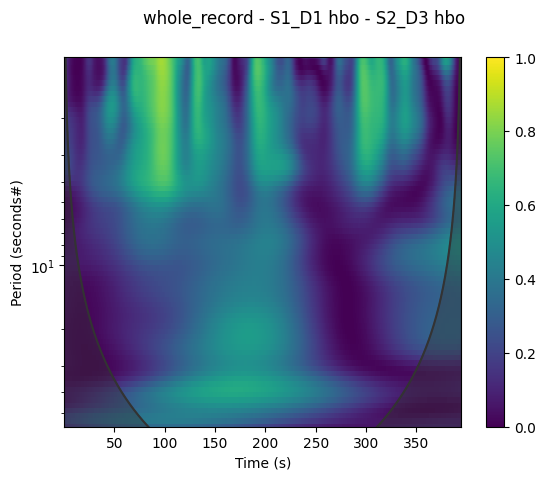

Downscaling for display by a factor of 4


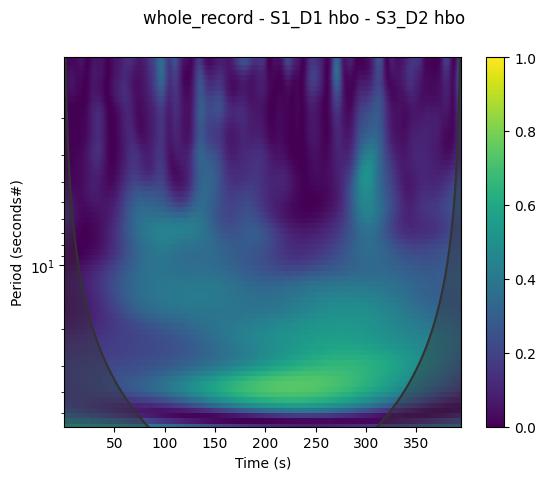

In [6]:
for i in range(5):
    dyad_intra_subject.plot_wtc(dyad_intra_subject.wtcs[i])
    plt.show()


## Cohort


In [ ]:
# Instanciate subjects and dyads objects

preprocessor = fnirs.MnePreprocessor()
#tasks = [
#    ('first_10_seconds', 0, 10),
#    ('20_to_40_seconds', 20, 40),
#]
tasks = [
    ('first_30_seconds', 0, 30),
    ('second_minute', 60, 120),
]

#[MemoryMonitor] allocated: 21.37 M, peak: 36.50 M
with MemoryMonitor():
    all_dyads = []

    # truncate for this example
    dyad_paths_keys = list(dyad_paths.keys())[:6]

    for dyad_key in dyad_paths_keys:
        path_parent, path_child = dyad_paths[dyad_key]
        parent = fnirs.Subject(label=f'Parent {dyad_key}', tasks_time_range=tasks).load_file(preprocessor, path_parent)
        child = fnirs.Subject(label=f'Child {dyad_key}', tasks_time_range=tasks).load_file(preprocessor, path_child)
        dyad = fnirs.Dyad(parent, child, label=dyad_key)
        all_dyads.append(dyad)

    cohort = fnirs.Cohort(all_dyads)
    


Loading /home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS01/parent/NIRS-2019-09-28_002.hdr


Reading 0 ... 3083  =      0.000 ...   394.624 secs...
Loading /home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS01/child/NIRS-2019-09-28_002.hdr
Reading 0 ... 3083  =      0.000 ...   394.624 secs...
Loading /home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS02/parent/NIRS-2019-10-06_004.hdr
Reading 0 ... 4489  =      0.000 ...   574.592 secs...
Loading /home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS02/child/NIRS-2019-10-06_004.hdr
Reading 0 ... 4489  =      0.000 ...   574.592 secs...
Loading /home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS03/parent/NIRS-2019-10-12_003.hdr
Reading 0 ... 4858  =      0.000 ...   621.824 secs...
Loading /home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS03/child/NIRS-2019-10-12_003.hdr
Reading 0 ... 4858  =      0.000 ...   621.824 secs...
Loading /home/patrice/work/ppsp/HyPyP-synchro/data/fNIRS/downloads/fathers/FCS04/parent/NIRS-2019-10-12_001.hdr
R

In [41]:
# Preprocess all dyads
with MemoryMonitor():
    old_level = mne.set_log_level(verbose='WARNING', return_old_level=True)
    cohort.preprocess(preprocessor)
    mne.set_log_level(verbose=old_level)

[MemoryMonitor] allocated: 348.08 k, peak: 450.72 k


In [9]:
# use caching to avoid recomputing continuous wavelet transforms all the time
# the cache dictionary is shared by all dyads
cache = dict()
wavelet = PywaveletsWavelet(cache_dict=cache)


In [36]:


# Compute Wavelet Coherence for every dyad
with MemoryMonitor():
    cohort.compute_wtcs(verbose=True, match='hbo', wavelet=wavelet)


Running Wavelet Coherence for dyad "FCS01" on pair "second_minute - S1_D1 hbo - S1_D1 hbo"
Running Wavelet Coherence for dyad "FCS01" on pair "second_minute - S1_D1 hbo - S1_D2 hbo"
Running Wavelet Coherence for dyad "FCS01" on pair "second_minute - S1_D1 hbo - S2_D1 hbo"
Running Wavelet Coherence for dyad "FCS01" on pair "second_minute - S1_D1 hbo - S2_D3 hbo"
Running Wavelet Coherence for dyad "FCS01" on pair "second_minute - S1_D1 hbo - S3_D2 hbo"
Running Wavelet Coherence for dyad "FCS01" on pair "second_minute - S1_D1 hbo - S3_D3 hbo"
Running Wavelet Coherence for dyad "FCS01" on pair "second_minute - S1_D1 hbo - S3_D4 hbo"
Running Wavelet Coherence for dyad "FCS01" on pair "second_minute - S1_D1 hbo - S4_D2 hbo"
Running Wavelet Coherence for dyad "FCS01" on pair "second_minute - S1_D1 hbo - S4_D4 hbo"
Running Wavelet Coherence for dyad "FCS01" on pair "second_minute - S1_D1 hbo - S4_D5 hbo"
Running Wavelet Coherence for dyad "FCS01" on pair "second_minute - S1_D1 hbo - S5_D3 hbo"

In [39]:
# [MemoryMonitor] allocated: 1.39 G, peak: 1.39 G
with MemoryMonitor():
    cohort.compute_wtcs_shuffle(verbose=True, match='hbo', wavelet=wavelet).compute_wtcs_significance()


Running Wavelet Coherence for dyad "shuffle s1:FCS01-s2:FCS02" on pair "second_minute - S1_D1 hbo - S1_D1 hbo"
Running Wavelet Coherence for dyad "shuffle s1:FCS01-s2:FCS02" on pair "second_minute - S1_D1 hbo - S2_D1 hbo"
Running Wavelet Coherence for dyad "shuffle s1:FCS01-s2:FCS02" on pair "second_minute - S1_D1 hbo - S2_D3 hbo"
Running Wavelet Coherence for dyad "shuffle s1:FCS01-s2:FCS02" on pair "second_minute - S1_D1 hbo - S3_D3 hbo"
Running Wavelet Coherence for dyad "shuffle s1:FCS01-s2:FCS02" on pair "second_minute - S1_D1 hbo - S3_D4 hbo"
Running Wavelet Coherence for dyad "shuffle s1:FCS01-s2:FCS02" on pair "second_minute - S1_D1 hbo - S4_D2 hbo"
Running Wavelet Coherence for dyad "shuffle s1:FCS01-s2:FCS02" on pair "second_minute - S1_D1 hbo - S4_D4 hbo"
Running Wavelet Coherence for dyad "shuffle s1:FCS01-s2:FCS02" on pair "second_minute - S1_D1 hbo - S4_D5 hbo"
Running Wavelet Coherence for dyad "shuffle s1:FCS01-s2:FCS02" on pair "second_minute - S1_D1 hbo - S5_D3 hbo"
R

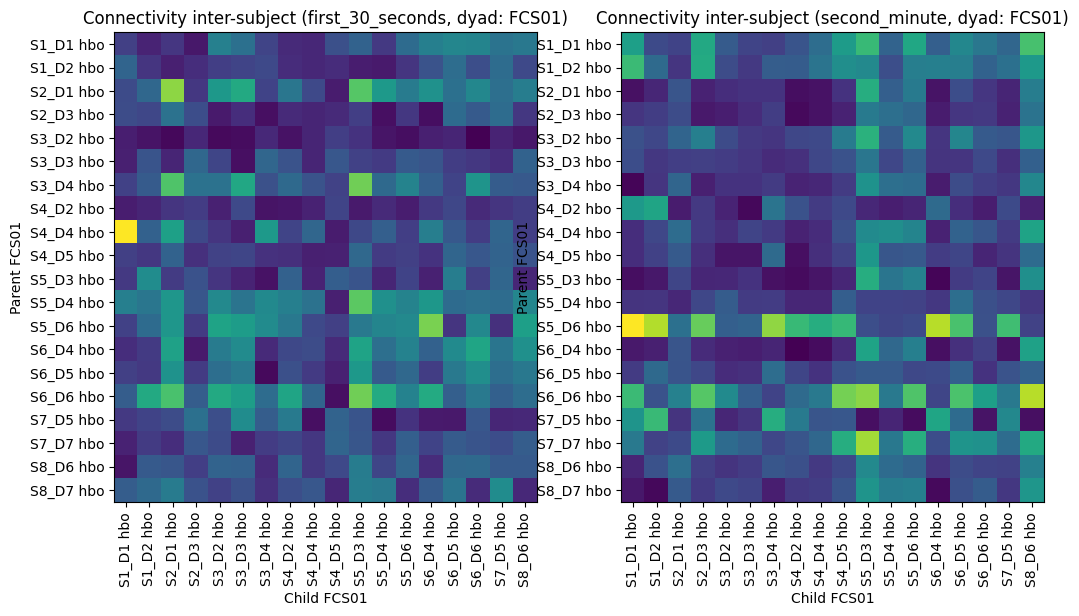

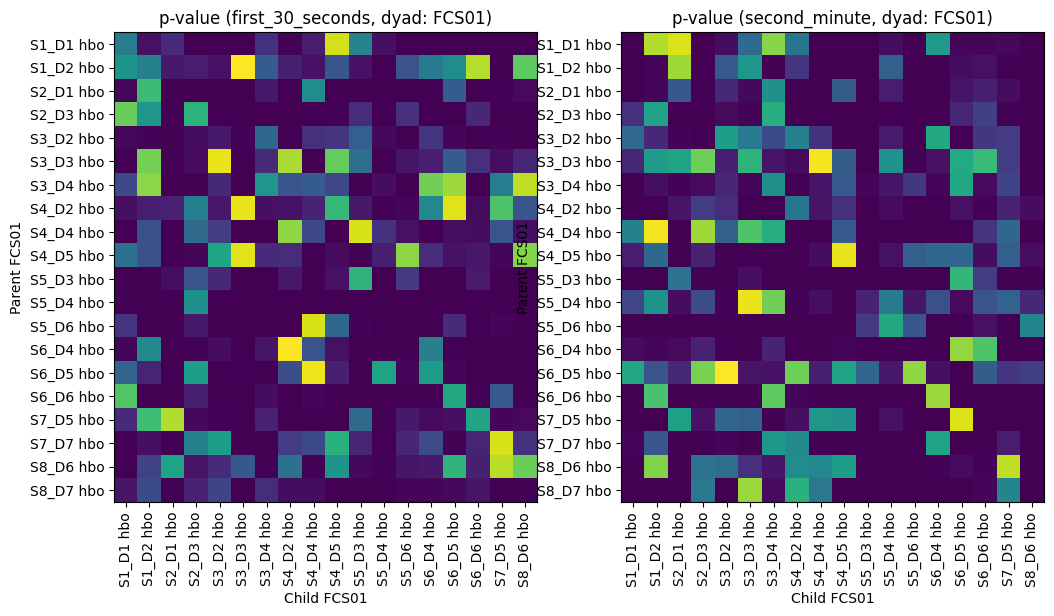

In [12]:
# Plot significance metric

def plot_matrix_for_dyad(dyad, res, title):
    mat, tasks, ch_names1, ch_names2 = res
    fig, axes = plt.subplots(1, len(tasks), figsize=(12, 8))

    for i in range(len(tasks)):
        try:
            ax = axes[i]
        except:
            ax = axes
        ax.imshow(mat[i,:,:])
        ax.set_title(f'{title} ({tasks[i]}, dyad: {dyad.label})')
        #ax.colorbar()

        # Set x and y ticks
        ax.set_yticks(ticks=np.arange(len(ch_names1)), labels=ch_names1)
        ax.set_xticks(ticks=np.arange(len(ch_names2)), labels=ch_names2, rotation=90)

        ax.set_ylabel(dyad.s1.label)
        ax.set_xlabel(dyad.s2.label)

    plt.show

dyad = cohort.dyads[0]
plot_matrix_for_dyad(dyad, dyad.get_connectivity_matrix(), 'Connectivity inter-subject')

plot_matrix_for_dyad(dyad, dyad.get_p_value_matrix(), 'p-value')


In [42]:
# Save to disk

results_file_path = '../data/results/fnirs_cohort_example.pickle'
cohort.save_pickle(results_file_path)


In [14]:
# Add the "intra subject" dyad in the cohort for visualisation

# Append to the cohort "dyads" for intra-subject visualisation
dyads_intra_subject = []
for dyad in cohort.dyads:
    for subject in [dyad.s1, dyad.s2]:
        dyads_intra_subject.append(fnirs.Dyad(subject, subject, label=f'intra-subject ({subject.label})').populate_epochs_from_tasks().compute_wtcs(match='hbo'))

cohort_intra_subject = fnirs.Cohort(dyads_intra_subject)
results_file_path = '../data/results/fnirs_cohort_example_intra_subject.pickle'
cohort_intra_subject.save_pickle(results_file_path)



Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 235 original time points ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 470 original time points ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 235 original time points ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 470 original time points ...
0 bad epochs dropped
Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1 events and 235 original time points ...
0 bad epoch

In [38]:
import sys
sys.getsizeof(cache)

13056